In [1]:
import numpy as np
import torch 

from braindecode.datasets.base import BaseConcatDataset
from braindecode.datasets import TUHAbnormal
from braindecode import EEGClassifier
from braindecode.models import ShallowFBCSPNet, deep4
from braindecode.preprocessing import create_fixed_length_windows

from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer



import mne
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

n_jobs = 4
data_path = '/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal_clip/v2.0.0/edf/'
#N_SAMPLES = 100
N_JOBS = 8 

/home/jovyan/test_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
tuabn = TUHAbnormal(
        path=data_path,
        preload=False,  # True
        add_physician_reports=True, 
        n_jobs=n_jobs,
        target_name = "report",
        #recording_ids=range(5,11),
    )


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [3]:
print(len(tuabn))
x, y = tuabn[-1]
print('x:', x)
print('y:', y)

793600
x: [[ 6.98874172e-08]
 [ 2.14231788e-07]
 [-1.46629139e-07]
 [-1.10543046e-07]
 [-1.82715232e-07]
 [-2.28476821e-09]
 [-1.10543046e-07]
 [-3.83708609e-08]
 [-3.83708609e-08]
 [-3.83708609e-08]
 [ 3.22490066e-07]
 [ 6.98874172e-08]
 [-2.28476821e-09]
 [-3.83708609e-08]
 [-1.10543046e-07]
 [-3.83708609e-08]
 [ 1.05973510e-07]
 [-1.82715232e-07]
 [-2.28476821e-09]
 [-3.83708609e-08]
 [-3.83708609e-08]]
y: 

HISTORY: 69 year old male with psychiatric symptoms, boarding home resident and syncope versus seizure.

MEDICATIONS: Clozapine, Metformin, Avandia, Diovan, Metformin, Amiodipine


INTRODUCTION: Digital video EEG was performed in lab/bed using standard 10-20 system of electrode placement with 1 channel of EKG.  Hyperventilation and photic simulation are preformed.  This is an awake record. The EKG lead is not functioning.

DESCRIPTION OF THE RECORD: The background EEG demonstrates rhythmic background slowing. There is a posterior dominant rhythm of 6-7 hertz, a scant amount of a

In [4]:
import sys
sys.path.insert(0, '..')
from text_preprocessing.text_preprocessing import text_preprocessing


In [13]:
tuabn.description

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological
0,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False
1,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False
2,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False
3,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False
4,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2013,10,7,6881,2,1,51,F,CLINICAL HISTORY: 50-year-old woman with a his...,v2.0.0,True,True
2989,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2013,10,7,7757,3,1,40,F,"CLINICAL HISTORY: A 38-year-old woman, with u...",v2.0.0,True,False
2990,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2013,10,7,9289,4,1,22,M,CLINICAL HISTORY: A 22-year-old with refractor...,v2.0.0,True,True
2991,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2013,10,10,3240,2,1,55,F,CLINICAL HISTORY: A 55-year-old woman with re...,v2.0.0,True,False


In [14]:
tuabn.set_description(text_preprocessing(tuabn.description), overwrite=True)

In [19]:
tuabn.description["REPORT"].iloc[200]

'age: 21, gender: M, pathological: True, IMPRESSION: Abnormal EEG due to: 1. Background slowing. 2. Frontal spike and slow wave activity and left frontal spike and stow wave activity., DESCRIPTION OF THE RECORD: In wakefulness, the background EEG is slow, disorganized, and lacking in the normal morphologies of an awake EEG. Hyperventilation is performed early in the record and produces occasional bursts of rhythmic, bifrontal sharp waves. In stage 1 and stage 2 sleep there are rudimentary vertex waves and spindles. In addition, frontally predominant spike and wave and polyspike and wave complexes with a slow spike and wave frequency are identified. These are maximum on the left, but have some bilateral representation. Photic stimulation does not clearly activate the record and is performed while the Individual in stage 2 sleep where the epileptiform activity is prominent., CLINICAL HISTORY: 20 year old male with mental retardation and epilepsy., MEDICATIONS: Depakote, Ativan, Keppra, T

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


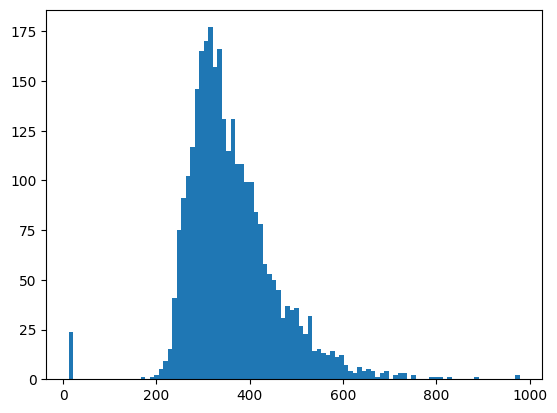

361.20347477447376


In [16]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
bert_tokenizer = AutoTokenizer.from_pretrained("hkunlp/instructor-xl")
#bert_model = AutoModel.from_pretrained("bert-base-uncased")
token_list = []
for report in tuabn.description["REPORT"].to_list():
    token_list.append(bert_tokenizer.tokenize(report))

#print(token_list[0])
#draw a histogram of the number of tokens in each string
import matplotlib.pyplot as plt
plt.hist([len(x) for x in token_list], bins=100)
plt.show()
print(np.mean([len(x) for x in token_list]))


In [21]:
print(np.mean([len(x)<512 for x in token_list]))

0.9271633812228534


In [22]:
token_list[200]

['▁age',
 ':',
 '▁21,',
 '▁gender',
 ':',
 '▁M',
 ',',
 '▁path',
 'ological',
 ':',
 '▁True',
 ',',
 '▁',
 'IM',
 'PRES',
 'S',
 'ION',
 ':',
 '▁Ab',
 'normal',
 '▁E',
 'EG',
 '▁due',
 '▁to',
 ':',
 '▁1.',
 '▁Background',
 '▁slow',
 'ing',
 '.',
 '▁2.',
 '▁Front',
 'al',
 '▁spike',
 '▁and',
 '▁slow',
 '▁wave',
 '▁activity',
 '▁and',
 '▁left',
 '▁front',
 'al',
 '▁spike',
 '▁and',
 '▁',
 's',
 't',
 'ow',
 '▁wave',
 '▁activity',
 '.',
 ',',
 '▁D',
 'ESC',
 'RIP',
 'TION',
 '▁OF',
 '▁THE',
 '▁',
 'REC',
 'ORD',
 ':',
 '▁In',
 '▁wake',
 'fulness',
 ',',
 '▁the',
 '▁background',
 '▁E',
 'EG',
 '▁is',
 '▁slow',
 ',',
 '▁dis',
 'organized',
 ',',
 '▁and',
 '▁lacking',
 '▁in',
 '▁the',
 '▁normal',
 '▁',
 'morph',
 'ologie',
 's',
 '▁of',
 '▁an',
 '▁awake',
 '▁E',
 'EG',
 '.',
 '▁Hyper',
 'vent',
 'il',
 'ation',
 '▁is',
 '▁performed',
 '▁early',
 '▁in',
 '▁the',
 '▁record',
 '▁and',
 '▁produces',
 '▁occasional',
 '▁bur',
 's',
 't',
 's',
 '▁of',
 '▁rhythm',
 'ic',
 ',',
 '▁bi',
 'front',
 'a

In [9]:
full_desc.duplicated(subset=['SUBJECT'])

0       False
1       False
2       False
3       False
4       False
        ...  
2989     True
2990     True
2991    False
2992    False
2993    False
Length: 2994, dtype: bool

In [10]:
tuabn.description[tuabn.description.subject.isin([4933,6523])]["pathological"].tolist()

[]

In [11]:
full_desc[full_desc["SUBJECT"]==subject_id].iloc[0]["DESCRIPTION OF THE RECORD"]

NameError: name 'subject_id' is not defined

In [ ]:
sfreq  = 100
n_minutes = 20

subject_datasets = tuabn.split('subject')
n_subjects = len(subject_datasets)

n_split = int(np.round(n_subjects * 0.75))
keys = list(subject_datasets.keys())
train_sets = [d for i in range(n_split) for d in subject_datasets[keys[i]].datasets]
train_set = BaseConcatDataset(train_sets)
valid_sets = [d for i in range(n_split, n_subjects) for d in subject_datasets[keys[i]].datasets]
valid_set = BaseConcatDataset(valid_sets)



In [ ]:
window_size_samples = 1000
window_stride_samples = 1000

window_train_set = create_fixed_length_windows(
    train_set,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=True,
    n_jobs=N_JOBS,

)
window_valid_set = create_fixed_length_windows(
    valid_set,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    n_jobs=N_JOBS,

)


Loading data for 120 events and 1000 original time points ...
Loading data for 140 events and 1000 original time points ...
Loading data for 120 events and 1000 original time points ...
Loading data for 120 events and 1000 original time points ...
Loading data for 125 events and 1000 original time points ...
Loading data for 120 events and 1000 original time points ...
Loading data for 118 events and 1000 original time points ...
Loading data for 125 events and 1000 original time points ...
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
Loading data for 138 events and 1000 original time points ...
Loading data for 122 events and 1000 original time points ...
Loading data for 119 events and 1000 original time points ...
Loading data for 121 events and 1000 original time points ...
Loading data for 120 events and 1000 original time points ...
Loading data for 115 event

In [ ]:

batch_size = 32
num_workers = 32
n_epochs = 50

train_loader = torch.utils.data.DataLoader(
    window_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True)
valid_loader = torch.utils.data.DataLoader(
    window_valid_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)





In [ ]:


n_classes = 128
# Extract number of chans and time steps from dataset
n_chans = window_train_set[0][0].shape[0]
input_window_samples = window_train_set[0][0].shape[1]

eeg_classifier_model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)


# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001


logger = TensorBoardLogger("results/tb_logs", name="EEG_Clip")

trainer = Trainer(
    devices=1,
    accelerator="gpu",
    max_epochs=n_epochs,
    #callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=logger,
    profiler="advanced"
)

trainer.fit(EEGClipModule(eeg_classifier_model=eeg_classifier_model, lr = lr), train_loader, valid_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'valid_loader' is not defined